In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import RandomFlip, RandomContrast, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.applications import EfficientNetV2L as base_m
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy as scc
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

SEED = 154
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

print(f'Tensorflow version: {tf.__version__}')

D0916 11:38:38.359065532      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0916 11:38:38.359095497      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0916 11:38:38.359099120      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0916 11:38:38.359101897      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0916 11:38:38.359104385      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0916 11:38:38.359107147      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0916 11:38:38.359109556      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0916 11:38:38.

Tensorflow version: 2.12.0


In [2]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
strategy = tf.distribute.TPUStrategy(tpu)
print("Running on TPU")
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [3]:
image_size = (480,480)
epochs = 60
tf_record_sample_size = 4096
batch_size = 128 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
train = tf.io.gfile.glob("/kaggle/input/*/tfrecords/*.tfrec")

In [4]:
filenames = tf.io.gfile.glob("/kaggle/input/*/tfrecords/*.tfrec")
filenames.sort()
random.Random(SEED).shuffle(filenames)

train_split = 0.8
val_split = 0.1

num_files = len(filenames)
train_end = int(train_split * num_files)
val_end = int((train_split + val_split) * num_files)

train_filenames = filenames[:train_end]
val_filenames = filenames[train_end:val_end]
test_filenames = filenames[val_end:]

In [5]:
# def decode_image(image_data):
#     image = tf.image.decode_jpeg(image_data, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0
#     image = tf.reshape(image, [*image_size, 3])
#     return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "feature0": tf.io.FixedLenFeature([], tf.string),
        "feature1": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = tf.io.decode_jpeg(example['feature0'])
    label = tf.cast(example['feature1'], tf.int64)
    return image, label

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
#     options = tf.data.Options()
#     options.experimental_deterministic = True
#     dataset = dataset.with_options(options)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.stateless_random_flip_left_right(image, seed=(SEED, SEED))
    image = tf.image.stateless_random_saturation(image, lower=0.8, upper=2.0, seed=(SEED + 1, SEED + 1))
    return image, label

def get_dataset(filenames, augment=False, repeat=False):
    dataset = load_dataset(filenames)
    dataset_size = (len(filenames) - 1) * tf_record_sample_size
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=SEED)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset, dataset_size

In [6]:
train_ds, train_size = get_dataset(train_filenames, augment=True, repeat=True)
val_ds, val_size = get_dataset(val_filenames)
test_ds, test_size = get_dataset(test_filenames)

In [7]:
def create_model():
    data_augmentation = Sequential([
        RandomFlip('horizontal'),
        RandomContrast(0.2),
    ])

    base_model = base_m(input_shape=(*image_size, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        data_augmentation,
        base_model,
        GlobalAveragePooling2D(),
        Dense(4096, activation='swish'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1024, activation='swish'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1000)
    ])

    model.compile(
        optimizer=Adam(lr_init),
        loss=scc(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [8]:
lr_init = 0.003
es = EarlyStopping(
    monitor='val_loss',
    patience=8,
    min_delta=0.005,
    restore_best_weights=True,
    verbose=1
)

In [9]:
def schedule(epoch,lr):
    if epoch < 10:
        return (epoch+1)*lr_init/10
    elif epoch < 20:
        return lr
    return lr * tf.math.exp(-0.1)
lr_scheduler = LearningRateScheduler(schedule,verbose=1)

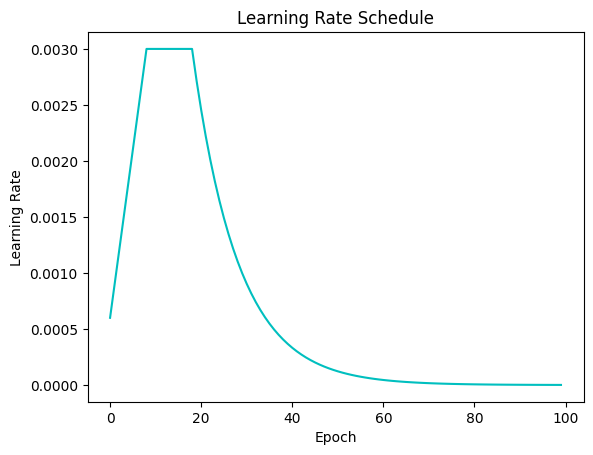

In [10]:
lr = 0.003
x = list(range(100))
y = []
for i in range(100):
    lr = schedule(i + 1, lr)
    y.append(lr)

plt.plot(x, y, c="c")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

In [11]:
if not os.path.exists("chkpts"):
    os.makedirs("chkpts")
    
checkpoint_filepath = 'chkpts/best_loss_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_format='h5'
)

In [12]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [13]:
with strategy.scope():
    model = keras.models.load_model("/kaggle/input/birdly-main-trainer-phase-3/model.h5")
#     model = create_model()

In [14]:
steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

In [15]:
history = model.fit(
    train_ds,
    initial_epoch = 36,
    epochs=epochs,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[es, model_checkpoint_callback, lr_scheduler]
)


Epoch 37: LearningRateScheduler setting learning rate to 0.0005480506806634367.
Epoch 37/60


2024-09-16 11:40:38.029524: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2024-09-16 11:40:39.616287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


644/644 [==============================] - ETA: 0s - loss: 0.4643 - accuracy: 0.8565

2024-09-16 11:59:25.358337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-09-16 11:59:26.164353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


644/644 [==============================] - 1293s 2s/step - loss: 0.4643 - accuracy: 0.8565 - val_loss: 0.6424 - val_accuracy: 0.8314 - lr: 5.4805e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0004958967911079526.
Epoch 38/60
644/644 [==============================] - 1184s 2s/step - loss: 0.4662 - accuracy: 0.8553 - val_loss: 0.6356 - val_accuracy: 0.8333 - lr: 4.9590e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.00044870597776025534.
Epoch 39/60
644/644 [==============================] - 1188s 2s/step - loss: 0.4607 - accuracy: 0.8567 - val_loss: 0.6241 - val_accuracy: 0.8358 - lr: 4.4871e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.00040600597276352346.
Epoch 40/60
644/644 [==============================] - 1179s 2s/step - loss: 0.4568 - accuracy: 0.8579 - val_loss: 0.6214 - val_accuracy: 0.8371 - lr: 4.0601e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.00036736938636749983.
Epoch 41/60
644/644 [================

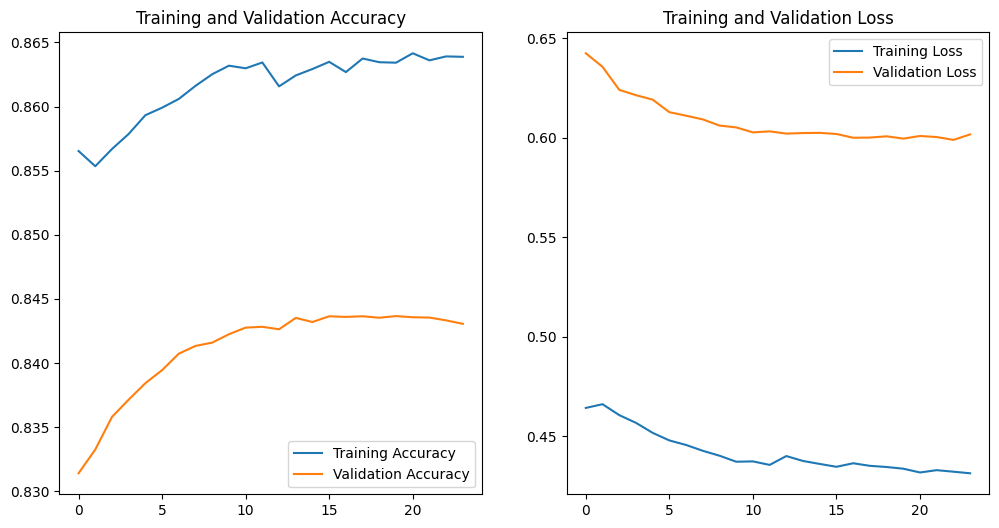

In [16]:
plot_history(history)

In [17]:
model.save('model.h5')

In [18]:
import pickle

with open('train_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [19]:
test_steps = test_size // batch_size
if test_size % batch_size != 0:
    test_steps += 1

test_loss, test_accuracy = model.evaluate(test_ds, steps=test_steps)

test_loss = round(test_loss, 2)
test_accuracy = round(test_accuracy * 100, 2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}%")

80/80 [==============================] - 115s 1s/step - loss: 0.6679 - accuracy: 0.8202
Test Loss: 0.67
Test Accuracy: 82.02%
